In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [2]:
LIB_SIZE = 5021
N_ATOMS = 10
MAX_MASS_DIFF = 300.0

atoms = ("I", "Br", "Cl", "S", "P", "F", "O", "N", "C", "H")
atom2ind = {"I": 0, "Br": 1, "Cl": 2, "S": 3, "P": 4, "F": 5, "O": 6, "N": 7, "C": 8, "H": 9}
atom_masses = np.array([126.904468, 78.9183376, 34.96885271, 31.97207069, 30.97376151, 18.99840320, 
                        15.9949146221, 14.0030740052, 12.0, 1.0078250321]
                      )

## Собираем базу данных модификаций

In [49]:
def decompose_formula(formula):
    res = np.zeros(N_ATOMS, dtype=int)
    i, j, k = 0, 0, 0
    while i < len(formula):
        j = i + 1
        while j < len(formula) and formula[j].islower(): j += 1
        k = j
        while k < len(formula) and formula[k].isdigit(): k += 1
        atom = formula[i:j]
        if j == k:
            count = 1
        else:
            count = int(formula[j:k])
        res[atom2ind[atom]] += count
        i = k
    return res


def formula2mass(formula):
    return np.dot(decompose_formula(formula), atom_masses)


class PNP:
    
    def __init__(self, name, formula, mass, multiedges, structure):
        self.name = name
        self.formula = formula
        self.mass = mass
        self.multiedges = multiedges
        self.structure = structure
    
    
    def show(self, figsize=(7, 7), labels='formula'):
        print('name :', self.name)
        print('formula :', self.formula)
        print('mass :', self.mass)
        print(self.structure)
        fig = plt.figure(figsize=figsize)
        l = {}
        for i in range(self.size()):
            l[i] = self.structure.nodes[i][labels]
        nx.draw_networkx(self.structure, labels=l)
        return None
    
    
    def size(self):
        return self.structure.number_of_nodes()
    
    
    def atom_decomp(self, aa=-1):
        if aa == -1:
            formula = self.formula
        else:
            formula = self.structure.nodes[aa]['formula']
        return decompose_formula(formula)
    
    
    def aa_decomp(self):
        return Counter([self.structure.nodes[i]['formula'] for i in self.structure.nodes()])


In [4]:
path_pnpdb = '../side_sources/pnpdatabase/'

pnps = []

with open(path_pnpdb + 'pnp_AAGraphs.txt', 'r') as file:
    for ind in range(LIB_SIZE):
        _, name = file.readline().split()
        
        _, _, formula, _, _, mass = file.readline().split()
        mass = float(mass)
        
        _ = file.readline()
        *_, num_aa = file.readline().split()
        num_aa = int(num_aa)
        
        structure = nx.MultiDiGraph()
        
        for i in range(num_aa):
            AA_id, AA_formula, AA_mass = file.readline().split()
            AA_id = int(AA_id)
            AA_mass = float(AA_mass)
            structure.add_node(AA_id, formula=AA_formula, mass=AA_mass)
        
        *_, num_edges = file.readline().split()
        num_edges = int(num_edges)
        
        multiedges = False
        
        for i in range(num_edges):
            v1, bound, v2 = file.readline().split()
            assert bound == '-NC>'
            
            v1, v2 = int(v1), int(v2)
            if (v1, v2) in structure.edges:
                multiedges = True
            structure.add_edge(v1, v2)
        
        pnp_type = file.readline()[:-1]
        
        pnps.append(PNP(name, formula, mass, multiedges, structure))

In [5]:
replacements = []
amino_acids = set()

for ind1 in tqdm(range(LIB_SIZE)):
    amino_acids.update(list(pnps[ind1].aa_decomp().keys()))
    for ind2 in range(LIB_SIZE):
        p1 = pnps[ind1]
        p2 = pnps[ind2]
        if ind1 != ind2 and abs(p1.mass - p2.mass) < MAX_MASS_DIFF:
            AA_set1 = p1.aa_decomp()
            AA_set2 = p2.aa_decomp()
            gone = AA_set1 - AA_set2
            gain = AA_set2 - AA_set1
            if (sum(gone.values()) == 1) and (sum(gain.values()) == 1):
                diff = decompose_formula(list(gone)[0]) - decompose_formula(list(gain)[0])
                replacements.append(diff)
            

replacements = np.array(replacements)

  0%|          | 0/5021 [00:00<?, ?it/s]

name : Pyoverdin_Pp__Pyoverdin_Pp_1
formula : C57H83N17O25
mass : 1405.57
MultiDiGraph with 11 nodes and 10 edges
name : Pyoverdin-Pp1
formula : C57H84N17O25
mass : 1406.58
MultiDiGraph with 11 nodes and 10 edges


(None, None)

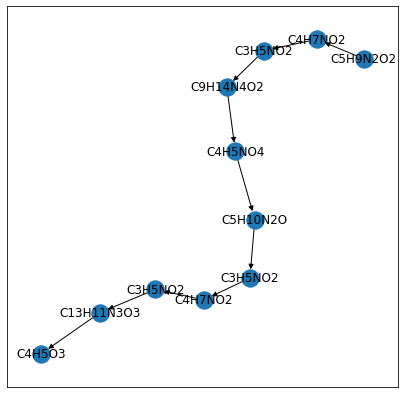

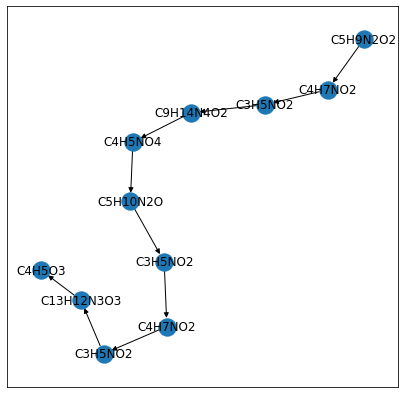

In [30]:
pnps[81].show(), pnps[4307].show()

Проанализируем результаты:

In [6]:
replacements

array([[ 0,  0,  0, ...,  0, -1, -2],
       [ 0,  0,  0, ...,  0, -2, -4],
       [ 0,  0,  0, ...,  0, -4, -6],
       ...,
       [ 0,  0,  0, ...,  0, -1, -2],
       [ 0,  0,  0, ...,  0,  0, -2],
       [ 0,  0,  0, ...,  0,  0,  2]])

In [7]:
replacements.shape

(14568, 10)

In [8]:
mod_masses = np.dot(replacements, atom_masses)

In [9]:
len(amino_acids)

1532

In [10]:
class Node:
    
    def __init__(self, pred):
        self.childs = dict()
        self.leaf = False
        self.pred = pred
        self.max_val = 0
    
    
    def __to_leaf(self):
        self.leaf = True
        self.vals = dict()
    
    
    def insert(self, row):
        if row.shape[0] == 1:
            if not self.leaf:
                self.__to_leaf()
            self.vals[row[0]] = self.vals.get(row[0], 0) + 1
            self.max_val = max(self.max_val, self.vals[row[0]])
        else:
            if not row[0] in self.childs.keys():
                self.childs[row[0]] = Node(pred=self) 
            self.childs[row[0]].insert(row[1:])
            self.max_val = max(self.max_val, self.childs[row[0]].max_val)
    
    def delete(self, row):
        if row.shape[0] == 1:
            self.vals[row[0]] -= 1
            self.max_val = max(self.vals.values())
        else:
            self.childs[row[0]].delete(row[1:])
            self.max_val = max([child.max_val for child in self.childs.values()])

In [91]:
class Distribution:
    
    def __init__(self, smooth_coef=10):
        self.smooth = smooth_coef
    
    
    def fit(self, data, amino_acids):
        
        # aprior normal distribution params
        self.cov = np.mean(np.square(np.append(data, [[1] * N_ATOMS], axis=0)), axis=0)
        self.__cov_inv = 1 / self.cov
        self.__aprior_dist_coef = np.sum(np.log(self.cov)) + N_ATOMS * np.log(2 * np.pi)
        
        # discrete distribution from data
        min_bound = np.abs(np.amin(data, axis=0))
        max_bound = np.abs(np.amax(data, axis=0))
        self.bound = np.amax([min_bound, max_bound], axis=0)
        self.data = Node(pred=None)
        for row in data:
            self.data.insert(row)
        
        # list of amino_acids
        self.aa_list = [(formula2mass(formula), formula) for formula in amino_acids]
        self.aa_list.sort()
    
    
    def add_row(self, row):
        self.data.insert(row)
    
    
    def del_row(self, row):
        self.data.delete(row)
    
    
    def aprior_prob(self, x):
        return np.exp(-0.5 * (np.dot(np.square(x), self.__cov_inv) + self.__aprior_dist_coef))
    
    
    @staticmethod
    def next_ind(i):
        if i > 0:
            return -i
        else:
            return -i + 1
    
    
    def search(self, mass, ind_no_H, cur_node, is_node_real):
        
        if ind_no_H.shape[0] == N_ATOMS - 1:
            num_H = round((mass - np.dot(ind_no_H, atom_masses[:-1])) / atom_masses[-1])
            ind = np.append(ind_no_H, num_H)
            p = self.smooth * self.aprior_prob(ind)
            if is_node_real:
                p += cur_node.vals.get(num_H, 0)
            if abs(np.dot(ind, atom_masses) - mass) < 0.02 and p > self.top_k[self.k - 1][0]:
                self.top_k[self.k - 1] = (p, tuple(ind))
                self.top_k.sort(reverse=True)
        else:
            i = 0
            while i <= self.bound[ind_no_H.shape[0]]:
                best_estimated_ind = np.append(ind_no_H, [i] + [0] * (N_ATOMS - 1 - ind_no_H.shape[0]))
                if is_node_real and (i in cur_node.childs.keys()):
                    estimated_p = cur_node.childs[i].max_val + self.smooth * self.aprior_prob(best_estimated_ind)
                    if estimated_p >= self.top_k[self.k - 1][0]:
                        self.search(mass, np.append(ind_no_H, [i]), cur_node.childs[i], True)
                else:
                    estimated_p = self.smooth * self.aprior_prob(best_estimated_ind)
                    if estimated_p >= self.top_k[self.k - 1][0]:
                        self.search(mass, np.append(ind_no_H, [i]), None, False)
                i = Distribution.next_ind(i)
    
    
    def predict(self, mass, k=5):
        self.k = k
        self.top_k = [(0.0, tuple([0] * N_ATOMS)) for i in range(k)]
        self.search(mass, np.array([], dtype=int), self.data, True)
        indels = []
        mass = abs(mass)
        if self.aa_list[0][0] <= mass + 0.02 and mass - 0.02 <= self.aa_list[-1][0]:
            i_begin = 0
            i_end = len(self.aa_list)
            while i_end - i_begin > 1:
                i_mid = (i_begin + i_end) // 2
                if self.aa_list[i_mid][0] < mass - 0.02:
                    i_begin = i_mid
                else:
                    i_end = i_mid
            i1 = i_begin
            i_begin = 0
            i_end = len(self.aa_list)
            while i_end - i_begin > 1:
                i_mid = (i_begin + i_end) // 2
                if self.aa_list[i_mid][0] <= mass + 0.02:
                    i_begin = i_mid
                else:
                    i_end = i_mid
            i2 = i_end
            for i in range(i1, i2):
                if abs(self.aa_list[i][0] - mass) < 0.02:
                    indels.append(self.aa_list[i])
        return self.top_k, indels

In [92]:
model = Distribution()
model.fit(np.array(replacements), amino_acids)

In [93]:
model.bound

array([ 1,  2,  3,  2,  1,  1, 10,  9, 20, 28])

In [94]:
model.cov

array([4.46152790e-03, 2.87596952e-02, 8.50435857e-02, 4.93513625e-02,
       1.99052783e-03, 3.22602787e-03, 1.29226440e+00, 6.90164047e-01,
       7.81199808e+00, 2.31950717e+01])

In [106]:
model.predict(112.052430, k=5)

([(4.1374341472834414e-01, (0, 0, 0, 0, 0, 0, 2, 1, 5, 6)),
  (0.2309242483611654, (0, 0, 0, 0, 0, 0, 2, 0, 6, 8)),
  (0.08218940271223604, (0, 0, 0, 0, 0, 0, 1, 2, 5, 8)),
  (0.03666303078026385, (0, 0, 0, 0, 0, 0, -1, 1, 9, 6)),
  (0.02241082081874804, (0, 0, 0, 0, 0, 0, 2, -1, 7, 10))],
 [(112.039853442, 'C5H6NO2'),
  (112.05242950099999, 'C6H8O2'),
  (112.06366288929999, 'C5H8N2O')])

In [82]:
model.aa_list

[(14.0030740052, 'N'),
 (15.0108990373, 'HN'),
 (15.0234750963, 'CH3'),
 (15.9949146221, 'O'),
 (27.994914622099998, 'CO'),
 (29.0027396542, 'CHO'),
 (29.0265491015, 'CH3N'),
 (30.0343741336, 'CH4N'),
 (31.018389718399998, 'CH3O'),
 (41.026549101499995, 'C2H3N'),
 (43.018389718399995, 'C2H3O'),
 (43.0421991657, 'C2H5N'),
 (44.0136386915, 'CH2NO'),
 (44.9976542763, 'CHO2'),
 (45.02146372359999, 'CH3NO'),
 (45.0340397826, 'C2H5O'),
 (46.0054793084, 'CH2O2'),
 (55.0421991657, 'C3H5N'),
 (55.989829244199996, 'C2O2'),
 (56.0136386915, 'C2H2NO'),
 (56.0500241978, 'C3H6N'),
 (57.02146372359999, 'C2H3NO'),
 (57.0340397826, 'C3H5O'),
 (57.0452731709, 'C2H5N2'),
 (57.0578492299, 'C3H7N'),
 (58.0054793084, 'C2H2O2'),
 (58.029288755699994, 'C2H4NO'),
 (58.040522144, 'CH4N3'),
 (58.065674262, 'C3H8N'),
 (59.01330434049999, 'C2H3O2'),
 (59.0245377288, 'CH3N2O'),
 (59.037113787799996, 'C2H5NO'),
 (59.0496898468, 'C3H7O'),
 (59.0609232351, 'C2H7N2'),
 (60.021129372599994, 'C2H4O2'),
 (60.0449388199, '